In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
train='Data/kdd_train.csv'

train_data=pd.read_csv(train)

In [5]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
train_data.shape

(125973, 42)

In [7]:
# number of attack labels 
train_data['labels'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: labels, dtype: int64

In [8]:
def change_label(df):
  df.labels.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.labels.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.labels.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.labels.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [9]:
change_label(train_data)

In [10]:
train_data = train_data[0:10000]

In [11]:
# distribution of attack classes
train_data.labels.value_counts()

normal    5292
Dos       3716
Probe      907
R2L         81
U2R          4
Name: labels, dtype: int64

In [12]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = train_data.copy()
multi_label = pd.DataFrame(multi_data.labels)

In [13]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [14]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label
#y_mul = multi_data['intrusion']
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,intrusion
0,-0.114,tcp,ftp_data,SF,-0.012415,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.762204,-0.286252,0.068685,-0.285355,-0.649655,-0.635631,-0.220111,-0.373724,normal,4
1,-0.114,udp,other,SF,-0.012505,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-1.140767,2.806543,2.364982,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,normal,4
2,-0.114,tcp,private,S0,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.918083,-0.177733,-0.481132,-0.285355,1.582292,1.592840,-0.384329,-0.373724,Dos,0
3,-0.114,tcp,http,SF,-0.012483,0.037581,0.0,-0.096529,-0.010001,-0.090616,...,1.086076,-0.449030,-0.384106,0.079479,-0.582697,-0.613347,-0.384329,-0.342206,normal,4
4,-0.114,tcp,http,SF,-0.012491,-0.034942,0.0,-0.096529,-0.010001,-0.090616,...,1.086076,-0.449030,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.114,tcp,uucp_path,S0,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-1.096230,-0.123473,-0.481132,-0.285355,1.582292,1.592840,-0.384329,-0.373724,Dos,0
9996,-0.114,tcp,http,SF,-0.012484,-0.035898,0.0,-0.096529,-0.010001,-0.090616,...,1.086076,-0.449030,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,normal,4
9997,-0.114,udp,domain_u,SF,-0.012532,-0.037699,0.0,-0.096529,-0.010001,-0.090616,...,1.063807,-0.394771,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,normal,4
9998,-0.114,tcp,private,REJ,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-1.073962,-0.069213,-0.481132,-0.285355,-0.649655,-0.635631,2.900026,2.778016,Dos,0


In [15]:
multi_data.drop(labels= [ 'labels'], axis=1, inplace=True)
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,-0.114,tcp,ftp_data,SF,-0.012415,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.797453,-0.762204,-0.286252,0.068685,-0.285355,-0.649655,-0.635631,-0.220111,-0.373724,4
1,-0.114,udp,other,SF,-0.012505,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-1.014314,-1.140767,2.806543,2.364982,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,4
2,-0.114,tcp,private,S0,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.788417,-0.918083,-0.177733,-0.481132,-0.285355,1.582292,1.592840,-0.384329,-0.373724,0
3,-0.114,tcp,http,SF,-0.012483,0.037581,0.0,-0.096529,-0.010001,-0.090616,...,1.280799,1.086076,-0.449030,-0.384106,0.079479,-0.582697,-0.613347,-0.384329,-0.342206,4
4,-0.114,tcp,http,SF,-0.012491,-0.034942,0.0,-0.096529,-0.010001,-0.090616,...,1.280799,1.086076,-0.449030,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.114,tcp,uucp_path,S0,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.969135,-1.096230,-0.123473,-0.481132,-0.285355,1.582292,1.592840,-0.384329,-0.373724,0
9996,-0.114,tcp,http,SF,-0.012484,-0.035898,0.0,-0.096529,-0.010001,-0.090616,...,1.280799,1.086076,-0.449030,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,4
9997,-0.114,udp,domain_u,SF,-0.012532,-0.037699,0.0,-0.096529,-0.010001,-0.090616,...,1.253691,1.063807,-0.394771,-0.481132,-0.285355,-0.649655,-0.635631,-0.384329,-0.373724,4
9998,-0.114,tcp,private,REJ,-0.012544,-0.038881,0.0,-0.096529,-0.010001,-0.090616,...,-0.951063,-1.073962,-0.069213,-0.481132,-0.285355,-0.649655,-0.635631,2.900026,2.778016,0


In [16]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
multi_data['protocol_type']= label_encoder.fit_transform(multi_data['protocol_type'])
multi_data['service']= label_encoder.fit_transform(multi_data['service'])
multi_data['flag']= label_encoder.fit_transform(multi_data['flag'])

multi_data['protocol_type'].unique()
multi_data['service'].unique()
multi_data['flag'].unique()

array([ 9,  5,  1,  4, 10,  2,  6,  3,  8,  7,  0], dtype=int64)

In [17]:
X = data.drop(["intrusion"],axis =1)
y = data["intrusion"]

# Feature Selection

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
rfecv = RFECV(cv=3, estimator=LogisticRegression(),
      scoring='accuracy')

rfecv.fit(X,y)

RFECV(cv=3, estimator=LogisticRegression(), scoring='accuracy')

In [19]:
#to get number of the features
display('Number of features:', rfecv.n_features_)

#to get feature names
list(X.columns[rfecv.support_]) 

'Number of features:'

25

['duration',
 'protocol_type',
 'flag',
 'src_bytes',
 'wrong_fragment',
 'hot',
 'logged_in',
 'num_compromised',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'is_guest_login',
 'count',
 'srv_serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [20]:
df = data[['duration',
 'protocol_type',
 'flag',
 'src_bytes',
 'wrong_fragment',
 'hot',
 'logged_in',
 'num_compromised',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'is_guest_login',
 'count',
 'srv_serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
             'intrusion']]
df.to_csv('kdd_processed.csv')

In [21]:
X_2 = data[['duration',
 'protocol_type',
 'flag',
 'src_bytes',
 'wrong_fragment',
 'hot',
 'logged_in',
 'num_compromised',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'is_guest_login',
 'count',
 'srv_serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']]

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 25), (8000,), (2000, 25), (2000,))

In [23]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []
auc = []
geo = []
spec = []
sens = []


#function to call for storing the results
def storeResults(model, a,b,c,d,e,f,g,h):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))
    auc.append(round(e,3))
    geo.append(round(f,3))
    spec.append(round(g,3))
    sens.append(round(h,3))
    

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, det_curve
from imblearn.metrics import geometric_mean_score,specificity_score,sensitivity_score

# Original

# SVM

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.984 total time=   3.0s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.985 total time=   3.1s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.983 total time=   3.0s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.988 total time=   2.9s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.988 total time=   3.0s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.984 total time=   0.9s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.985 total time=   0.9s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.986 total time=   1.0s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.989 total time=   1.0s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.983 total time=   0.9s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.971 total time=   1.1s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

In [26]:
svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_pred, y_test,average='weighted')
svm_rec = recall_score(y_pred, y_test,average='weighted')
svm_f1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc = roc_auc_score(y_train, svm.predict_proba(X_train), multi_class='ovr')
svm_geo = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec = specificity_score(y_test, y_pred, average='weighted')
svm_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - SVM',svm_acc,svm_prec,svm_rec,svm_f1,svm_auroc,svm_geo,svm_spec,svm_sens)

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = forest.predict(X_test)

In [28]:
rf_acc = accuracy_score(y_pred, y_test)
rf_prec = precision_score(y_pred, y_test,average='weighted')
rf_rec = recall_score(y_pred, y_test,average='weighted')
rf_f1 = f1_score(y_pred, y_test,average='weighted')
rf_auroc = roc_auc_score(y_train, forest.predict_proba(X_train), multi_class='ovr')
rf_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf_spec = specificity_score(y_test, y_pred, average='weighted')
rf_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - RF',rf_acc,rf_prec,rf_rec,rf_f1,rf_auroc,rf_geo,rf_spec,rf_sens)

# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = tree.predict(X_test)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


In [30]:
dt_acc = accuracy_score(y_pred, y_test)
dt_prec = precision_score(y_pred, y_test,average='weighted')
dt_rec = recall_score(y_pred, y_test,average='weighted')
dt_f1 = f1_score(y_pred, y_test,average='weighted')
dt_auroc = roc_auc_score(y_train, tree.predict_proba(X_train), multi_class='ovr')
dt_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt_spec = specificity_score(y_test, y_pred, average='weighted')
dt_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('Original - DT',dt_acc,dt_prec,dt_rec,dt_f1,dt_auroc,dt_geo,dt_spec,dt_sens)

# Stacking Classifier

In [77]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

In [35]:
stac_acc = accuracy_score(y_pred, y_test)
stac_prec = precision_score(y_pred, y_test,average='weighted')
stac_rec = recall_score(y_pred, y_test,average='weighted')
stac_f1 = f1_score(y_pred, y_test,average='weighted')
stac_auroc = roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr')
stac_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac_spec = specificity_score(y_test, y_pred, average='weighted')
stac_sens = sensitivity_score(y_test, y_pred, average='weighted')

#stac_acc
storeResults('Original - Stacking',stac_acc,stac_prec,stac_rec,stac_f1,stac_auroc,stac_geo,stac_spec,stac_sens)

# SVM - SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=2)
X_res, y_res = sm.fit_resample(X_2, y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 42)

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(X_test)

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_train, svm1.predict_proba(X_train), multi_class='ovr')
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.994 total time=   9.8s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.996 total time=   9.7s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.996 total time=   9.8s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.997 total time=   9.8s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.997 total time=   9.8s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.992 total time=   3.4s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.993 total time=   3.4s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.996 total time=   3.5s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.994 total time=   3.5s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.991 total time=   3.4s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.977 total time=   6.1s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(X_test)

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_train, forest1.predict_proba(X_train), multi_class='ovr')
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(X_test)

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_train, tree1.predict_proba(X_train), multi_class='ovr')
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('SMOTE - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [41]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

In [42]:
stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr')
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

#stac1_acc
storeResults('SMOTE-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# CDAAE

In [43]:
n_inputs = X_2.shape[1]

print(y[:5])

0    4
1    4
2    0
3    4
4    4
Name: intrusion, dtype: int32


In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs * 2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [46]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [47]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [48]:
history = model.fit(X_train, X_train, epochs=20, batch_size=2, verbose=0, validation_data=(X_test,X_test))

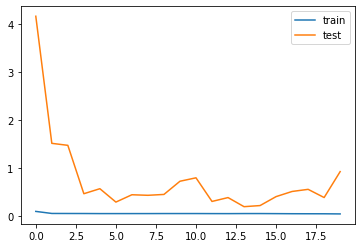

In [49]:
from matplotlib import pyplot

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
encoder = Model(inputs=visible, outputs=bottleneck)
#plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)

In [51]:
# save the encoder to file
encoder.save('encoder.h5')

In [52]:
# load the model from file
from keras.models import load_model
encoder = load_model('encoder.h5')

## We can then use the encoder to transform the raw input data (e.g. 100 columns) 
## into bottleneck vectors (e.g. 50 element vectors).
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

# SVM

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(X_test_encode)

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_train, svm1.predict_proba(X_train_encode), multi_class='ovr')
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.963 total time=   3.1s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.972 total time=   3.2s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.968 total time=   3.2s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.978 total time=   3.2s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.973 total time=   3.2s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.973 total time=   1.0s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.984 total time=   1.0s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.975 total time=   1.0s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.984 total time=   1.0s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.977 total time=   1.0s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.963 total time=   0.7s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# RAndom FOrest

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(X_test_encode)

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_train, forest1.predict_proba(X_train_encode), multi_class='ovr')
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(X_train_encode, y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(X_test_encode)

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_train, tree1.predict_proba(X_train_encode), multi_class='ovr')
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr')
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

#stac1_acc
storeResults('CDAAE-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# CDAAE-KNN

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.33, random_state=1)

In [58]:
import matplotlib.pyplot as plt
n_train = np.array(X_train)
n_test = np.array(X_test)

25
(6700, 25)


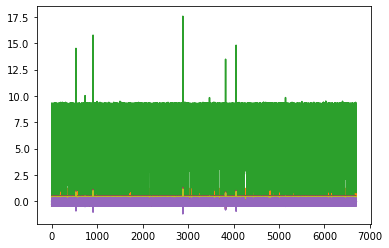

In [59]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

input_dim = n_train.shape[1]
feature_dim = [25, 20, 15, 10]
print(input_dim)
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(feature_dim[0], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[1], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[2], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[3], kernel_initializer="uniform")(encoded)

decoded = encoded
decoded = Dense(feature_dim[2], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[1], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[0], kernel_initializer="uniform")(decoded)
decoded = Dense(input_dim, kernel_initializer="uniform")(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(n_train, n_train,
                verbose=0,
                epochs=200,
                batch_size=2,
                shuffle=True,
                validation_data=(n_test, n_test))

predict_vals = autoencoder.predict(n_train)
print(predict_vals.shape)
plt.plot(predict_vals)
plt.show()

In [60]:
from keras.models import Sequential

featuremodel = Sequential()
featuremodel.add(Dense(feature_dim[0], input_shape=(input_dim,), weights=autoencoder.layers[1].get_weights()))
featuremodel.add(Dense(feature_dim[1], weights=autoencoder.layers[2].get_weights()))
featuremodel.add(Dense(feature_dim[2], weights=autoencoder.layers[3].get_weights()))
featuremodel.add(Dense(feature_dim[3], weights=autoencoder.layers[4].get_weights()))

featuremodel.compile(optimizer='adadelta', loss='mse')

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print("Accuracy: %s" % "{0:.3%}".format(metrics.accuracy_score(prediction, y_test)))

Accuracy: 98.727%


# SVM

In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

# instantiate the model 
svm1 = GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3)

# fit the model 
svm1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = svm1.predict(featuremodel.predict(n_test))

svm_acc1 = accuracy_score(y_pred, y_test)
svm_prec1 = precision_score(y_pred, y_test,average='weighted')
svm_rec1 = recall_score(y_pred, y_test,average='weighted')
svm_f1_1 = f1_score(y_pred, y_test,average='weighted')
svm_auroc1 = roc_auc_score(y_train, svm1.predict_proba(featuremodel.predict(n_train)), multi_class='ovr')
svm_geo1 = geometric_mean_score(y_test, y_pred, average='weighted')
svm_spec1 = specificity_score(y_test, y_pred, average='weighted')
svm_sens1 = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - SVM',svm_acc1,svm_prec1,svm_rec1,svm_f1_1,svm_auroc1,svm_geo1,svm_spec1,svm_sens1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............gamma=1, kernel=rbf;, score=0.873 total time=   1.4s
[CV 2/5] END ...............gamma=1, kernel=rbf;, score=0.875 total time=   1.5s
[CV 3/5] END ...............gamma=1, kernel=rbf;, score=0.867 total time=   1.4s
[CV 4/5] END ...............gamma=1, kernel=rbf;, score=0.875 total time=   1.5s
[CV 5/5] END ...............gamma=1, kernel=rbf;, score=0.878 total time=   1.5s
[CV 1/5] END .............gamma=0.1, kernel=rbf;, score=0.832 total time=   2.0s
[CV 2/5] END .............gamma=0.1, kernel=rbf;, score=0.838 total time=   2.0s
[CV 3/5] END .............gamma=0.1, kernel=rbf;, score=0.830 total time=   2.0s
[CV 4/5] END .............gamma=0.1, kernel=rbf;, score=0.849 total time=   2.0s
[CV 5/5] END .............gamma=0.1, kernel=rbf;, score=0.841 total time=   2.1s
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.830 total time=   2.6s
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

# Random FOrest

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {
    'n_estimators': [5,10,20,40,80,150]
}

forest1 = GridSearchCV(RandomForestClassifier(),param_grid=param_grid)
# fit the model 
forest1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = forest1.predict(featuremodel.predict(n_test))

rf1_acc = accuracy_score(y_pred, y_test)
rf1_prec = precision_score(y_pred, y_test,average='weighted')
rf1_rec = recall_score(y_pred, y_test,average='weighted')
rf1_f1 = f1_score(y_pred, y_test,average='weighted')
rf1_auroc = roc_auc_score(y_train, forest1.predict_proba(featuremodel.predict(n_train)), multi_class='ovr')
rf1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
rf1_spec = specificity_score(y_test, y_pred, average='weighted')
rf1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - RF',rf1_acc,rf1_prec,rf1_rec,rf1_f1,rf1_auroc,rf1_geo,rf1_spec,rf1_sens)

# Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [5,6,7,8,9,10,50,100]
}

tree1 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, cv=4, n_jobs=-1, verbose=1)

tree1.fit(featuremodel.predict(n_train), y_train)

#predicting the target value from the model for the samples

y_pred = tree1.predict(featuremodel.predict(n_test))

dt1_acc = accuracy_score(y_pred, y_test)
dt1_prec = precision_score(y_pred, y_test,average='weighted')
dt1_rec = recall_score(y_pred, y_test,average='weighted')
dt1_f1 = f1_score(y_pred, y_test,average='weighted')
dt1_auroc = roc_auc_score(y_train, tree1.predict_proba(featuremodel.predict(n_train)), multi_class='ovr')
dt1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
dt1_spec = specificity_score(y_test, y_pred, average='weighted')
dt1_sens = sensitivity_score(y_test, y_pred, average='weighted')

storeResults('CDAAE-KNN - DT',dt1_acc,dt1_prec,dt1_rec,dt1_f1,dt1_auroc,dt1_geo,dt1_spec,dt1_sens)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


# Stacking Classifier

In [64]:
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

estimators = [('et', ExtraTreesClassifier(n_estimators=100, random_state=0)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#predicting the target value from the model for the samples

y_pred = clf.predict(X_test)

stac1_acc = accuracy_score(y_pred, y_test)
stac1_prec = precision_score(y_pred, y_test,average='weighted')
stac1_rec = recall_score(y_pred, y_test,average='weighted')
stac1_f1 = f1_score(y_pred, y_test,average='weighted')
stac1_auroc = roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr')
stac1_geo = geometric_mean_score(y_test, y_pred, average='weighted')
stac1_spec = specificity_score(y_test, y_pred, average='weighted')
stac1_sens = sensitivity_score(y_test, y_pred, average='weighted')

#stac1_acc
storeResults('CDAAE-KNN-STACKING',stac1_acc,stac1_prec,stac1_rec,stac1_f1,stac1_auroc,stac1_geo,stac1_spec,stac1_sens)

# Comparison

In [65]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                       'AUC Score' : auc,
                       'Geometric Metric Score' : geo,
                       'Specificity' : spec,
                       'Sensitivity' : sens
                        
                      }) 

In [66]:
result

,ML Model,Accuracy,Precision,Recall,F1_score,AUC Score,Geometric Metric Score,Specificity,Sensitivity
0,Original - SVM,0.988,0.989,0.988,0.989,0.998,0.989,0.989,0.988
1,Original - RF,0.995,0.995,0.995,0.995,1.000,0.995,0.996,0.995
2,Original - DT,0.992,0.993,0.992,0.992,0.998,0.994,0.995,0.992
3,Original - Stacking,0.996,0.996,0.996,0.996,1.000,0.997,0.998,0.996
4,SMOTE - SVM,0.996,0.996,0.996,0.996,1.000,0.998,0.999,0.996
5,SMOTE - RF,0.999,0.999,0.999,0.999,1.000,1.000,1.000,0.999
6,SMOTE - DT,0.996,0.996,0.996,0.996,1.000,0.997,0.999,0.996
7,SMOTE-STACKING,0.998,0.998,0.998,0.998,1.000,0.999,1.000,0.998
8,CDAAE - SVM,0.972,0.973,0.972,0.972,0.997,0.974,0.976,0.972
9,CDAAE - RF,0.979,0.980,0.979,0.980,1.000,0.982,0.984,0.979


# Graph

In [67]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

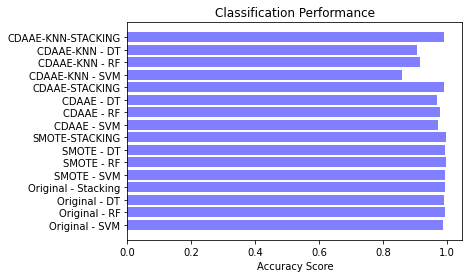

In [68]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

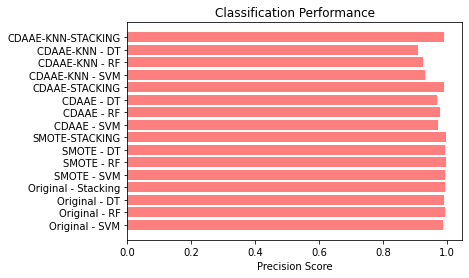

In [69]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

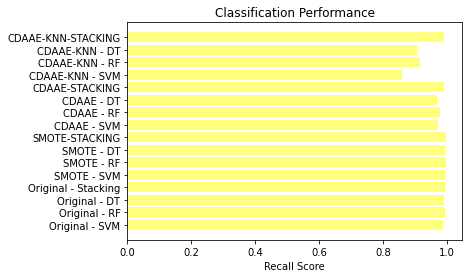

In [70]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1-Score

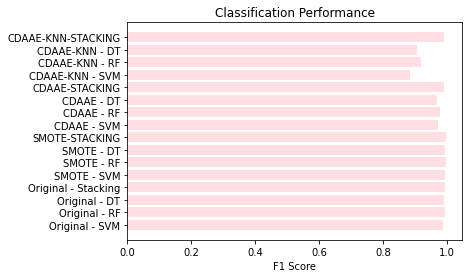

In [71]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# AUC Score

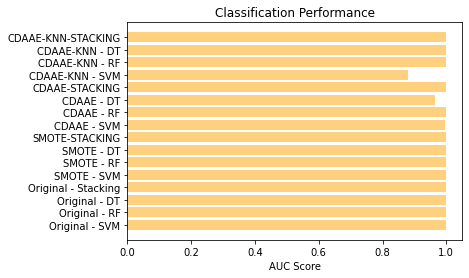

In [72]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, auc, align='center', alpha=0.5,color='orange')
plt2.yticks(y_pos, classifier)
plt2.xlabel('AUC Score')
plt2.title('Classification Performance')
plt2.show()

# Geometric Metric Score

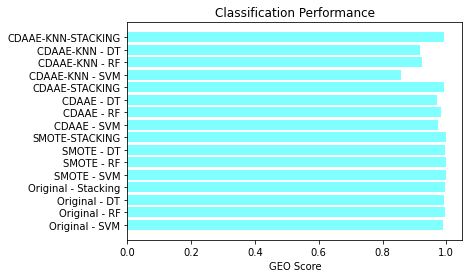

In [73]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, geo, align='center', alpha=0.5,color='cyan')
plt2.yticks(y_pos, classifier)
plt2.xlabel('GEO Score')
plt2.title('Classification Performance')
plt2.show()

# Specificity

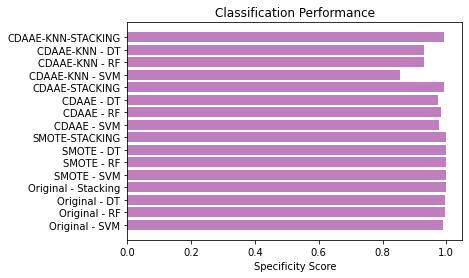

In [74]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, spec, align='center', alpha=0.5,color='purple')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Specificity Score')
plt2.title('Classification Performance')
plt2.show()

# Sensitivity

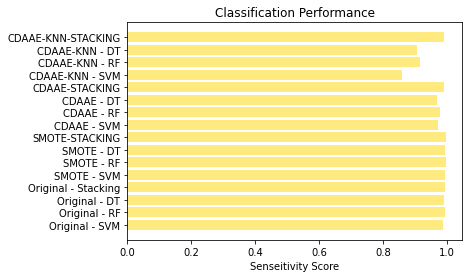

In [75]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, sens, align='center', alpha=0.5,color='gold')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Senseitivity Score')
plt2.title('Classification Performance')
plt2.show()

# Modelling

In [78]:
import joblib
filename = 'model_kdd.sav'
joblib.dump(clf, filename)

['model_kdd.sav']